In [1]:
import os

# Set working directory to the directory of the notebook file
os.chdir(os.path.dirname(os.path.realpath("__file__")))



In [3]:
os.chdir('../../BGF_clustering/cycle_division_split/cycle_splits_cdhit')

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import numpy as np
import pandas as pd

# ---------- Config ----------
output_dir = "./"  # folder containing your clstr2txt outputs
VALID_LEVELS = {20,30,40,50,60,70,80,90,100}

# Accept patterns: _30.txt, _c30.txt, _30.something.txt, _c30.something.txt (case-insensitive)
SIM_RE = re.compile(r"_(?:c)?(20|30|40|50|60|70|80|90|100)(?:[_\.][^/]*)?\.txt$", re.IGNORECASE)

# ---------- Buckets ----------
dataframes_20, dataframes_30, dataframes_40 = [], [], []
dataframes_50, dataframes_60, dataframes_70 = [], [], []
dataframes_80, dataframes_90, dataframes_100 = [], [], []

# ---------- Helpers ----------
def _read_table(path):
    """Try tab first; if one column only, fall back to whitespace."""
    try:
        df = pd.read_csv(path, sep="\t")
        if df.shape[1] == 1:
            df = pd.read_csv(path, sep=r"\s+", engine="python")
        return df
    except Exception as e:
        print(f"[WARN] Failed to read {path}: {e}")
        return pd.DataFrame()

def _normalize_id_series(s):
    """Make IDs comparable: strip, first token only, drop obvious empties."""
    s = s.astype(str).str.strip()
    s = s.str.split().str[0]
    s = s.replace({"": pd.NA})
    return s

def _dedup_best_per_id(d, id_col="id"):
    """Keep one row per id using explicit priority, robust to missing columns."""
    def safe_series(df, col, default=-1):
        if col in df.columns:
            return pd.to_numeric(df[col], errors="coerce").fillna(default)
        else:
            return pd.Series([default] * len(df), index=df.index)

    rep   = safe_series(d, "clstr_rep", 0).astype(int)   # prefer representatives
    size  = safe_series(d, "clstr_size", -1)             # prefer larger clusters
    pid   = safe_series(d, "pct_id", -1)                  # prefer higher identity (if present)
    aln   = safe_series(d, "aln_len", -1)                 # prefer longer alignments (if present)
    sfile = d["source_file"] if "source_file" in d.columns else pd.Series([""] * len(d), index=d.index)

    d = d.copy()
    d["_rep"]   = rep
    d["_size"]  = size
    d["_pid"]   = pid
    d["_aln"]   = aln
    d["_sfile"] = sfile.astype(str).fillna("")
    d["_order"] = np.arange(len(d))  # deterministic tie-breaker

    d = d.sort_values(
        by=["_rep","_size","_pid","_aln","_sfile","_order"],
        ascending=[False, False, False, False, True, True]
    )

    out = d.drop_duplicates(subset=[id_col], keep="first")
    removed = len(d) - len(out)
    if removed > 0:
        print(f"[INFO] Deduplicated {removed} rows (same id, same cluster) keeping best by priority.")
    return out.drop(columns=["_rep","_size","_pid","_aln","_sfile","_order"]).reset_index(drop=True)

def dedup_within_or_drop_across_clusters(df, id_col="id", clstr_col="clstr"):
    """
    Hybrid policy:
      - If an id maps to >1 distinct clstr in THIS file -> DROP ALL rows for that id.
      - Else if an id appears multiple times but all in the SAME clstr -> keep ONE best row.
      - Else (appears once) -> keep as-is.
    """
    if df.empty or id_col not in df.columns:
        return df

    d = df.copy()
    d[id_col] = _normalize_id_series(d[id_col])
    d = d.dropna(subset=[id_col]).reset_index(drop=True)

    if clstr_col not in d.columns:
        # No cluster info; fallback to best-per-id dedup only
        return _dedup_best_per_id(d, id_col=id_col)

    # Treat NaN as its own distinct cluster label for counting purposes
    cl = d[clstr_col].astype(str).replace({"nan": "<NA>"})
    distinct_per_id = cl.groupby(d[id_col]).nunique(dropna=False)

    # IDs to drop entirely (appear in >1 distinct cluster)
    ids_across_clusters = set(distinct_per_id[distinct_per_id > 1].index)
    if ids_across_clusters:
        before = len(d)
        d = d[~d[id_col].isin(ids_across_clusters)].copy()
        print(f"[INFO] Dropped {before - len(d)} rows from ids present in >1 cluster "
              f"({len(ids_across_clusters)} ids).")

    # Remaining: may still have multiple rows per id (same cluster) -> keep best one
    return _dedup_best_per_id(d, id_col=id_col).reset_index(drop=True)

def categorize_dataframes():
    matched, loaded = 0, 0

    for filename in os.listdir(output_dir):
        if not filename.endswith(".txt"):
            continue

        m = SIM_RE.search(filename)
        if not m:
            continue  # skip files that don't encode a similarity suffix
        level = int(m.group(1))
        if level not in VALID_LEVELS:
            continue
        matched += 1

        file_path = os.path.join(output_dir, filename)
        df = _read_table(file_path)
        if df.empty:
            print(f"[WARN] {filename}: empty or unreadable.")
            continue

        if "id" not in df.columns:
            print(f"[WARN] {filename}: no 'id' column; columns={list(df.columns)}")
            continue

        before = len(df)
        df = dedup_within_or_drop_across_clusters(df, id_col="id", clstr_col="clstr")
        print(f"[FILE] {filename}: {before} -> {len(df)} rows after hybrid de-dup policy")

        # Add metadata
        base = filename[: m.start()]  # part before the similarity suffix
        df["source_file"] = base
        df["similarity"] = level

        # Bucket by level
        if level == 20:   dataframes_20.append(df)
        elif level == 30: dataframes_30.append(df)
        elif level == 40: dataframes_40.append(df)
        elif level == 50: dataframes_50.append(df)
        elif level == 60: dataframes_60.append(df)
        elif level == 70: dataframes_70.append(df)
        elif level == 80: dataframes_80.append(df)
        elif level == 90: dataframes_90.append(df)
        elif level == 100: dataframes_100.append(df)
        loaded += 1

    print(f"[SUMMARY] matched files: {matched}, loaded & cleaned: {loaded}")

# ---------- Run ----------
if __name__ == "__main__":
    print("cwd:", os.getcwd())
    print("Scanning:", os.path.abspath(output_dir))
    categorize_dataframes()

    # Quick peek
    for lvl, dfs in [
        (20, dataframes_20), (30, dataframes_30), (40, dataframes_40),
        (50, dataframes_50), (60, dataframes_60), (70, dataframes_70),
        (80, dataframes_80), (90, dataframes_90), (100, dataframes_100)
    ]:
        if dfs:
            print(f"\nFirst dataframe with {lvl}% similarity ({len(dfs)} files loaded):")
            print(dfs[0].head())


cwd: /Users/wynne/Dropbox/BioGeoFormer/BGF_clustering/cycle_division_split/cycle_splits_cdhit
Scanning: /Users/wynne/Dropbox/BioGeoFormer/BGF_clustering/cycle_division_split/cycle_splits_cdhit
[INFO] Dropped 82003 rows from ids present in >1 cluster (15469 ids).
[INFO] Deduplicated 35 rows (same id, same cluster) keeping best by priority.
[FILE] purine_70.txt: 339631 -> 257593 rows after hybrid de-dup policy
[INFO] Deduplicated 1 rows (same id, same cluster) keeping best by priority.
[FILE] nitrogen_other_70.txt: 4455 -> 4454 rows after hybrid de-dup policy
[INFO] Dropped 9947 rows from ids present in >1 cluster (2756 ids).
[INFO] Deduplicated 8 rows (same id, same cluster) keeping best by priority.
[FILE] in_or_sul_90.txt: 130706 -> 120751 rows after hybrid de-dup policy
[INFO] Dropped 3344 rows from ids present in >1 cluster (1397 ids).
[INFO] Deduplicated 19 rows (same id, same cluster) keeping best by priority.
[FILE] pyruvate_80.txt: 33916 -> 30553 rows after hybrid de-dup policy


In [5]:
dataframes_20

[                     id  clstr  clstr_size  length  clstr_rep clstr_iden  \
 0            A0A4C1WJR4     40        5356     534          1        100   
 1            A0A3M4DFR4      0        3272     941          1        100   
 2            A0A1G5SIF8     95        2872     304          1        100   
 3                N0B2Y0     31        2657     563          1        100   
 4      1192034.CAP_2988     42        2430     524          1        100   
 ...                 ...    ...         ...     ...        ...        ...   
 22341    WP_151180598.1    356           2      63          0     98.41%   
 22342    WP_082294671.1    377           2      60          0     98.33%   
 22343    WP_080306350.1    391           2      57          0     98.25%   
 22344    WP_139861801.1    393           2      50          0     94.00%   
 22345    WP_088344046.1    395           2      28          0     50.00%   
 
       clstr_cov  source_file  similarity  
 0          100%  oxid_met_c1 

In [6]:
import pandas as pd

def summarize_dfs(df_list, similarity_label):
    summaries = []
    for df in df_list:
        summary = (
            df.groupby("source_file")
              .agg(
                  total_sequences=("id", "count"),
                  distinct_clusters=("clstr", "nunique")
              )
              .reset_index()
        )
        summary["similarity"] = similarity_label
        summaries.append(summary)
    return pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame()

# Collect summaries across all similarity groups
all_summaries = pd.concat([
    summarize_dfs(dataframes_40, "40"),
    summarize_dfs(dataframes_50, "50"),
    summarize_dfs(dataframes_60, "60"),
    summarize_dfs(dataframes_70, "70"),
    summarize_dfs(dataframes_80, "80"),
    summarize_dfs(dataframes_90, "90"),
], ignore_index=True)

print(all_summaries.head())


         source_file  total_sequences  distinct_clusters similarity
0          asssulred            79012               1097         40
1  oxid_formaldehyde            14817                146         40
2      nitrification            29898                 23         40
3           pyruvate            29409                230         40
4               rump            44598                452         40


In [7]:
import pandas as pd

def summarize_dfs(df_list, similarity_label):
    """Summarize a list of dfs for one similarity level."""
    summaries = []
    for df in df_list:
        # Defensive: ensure required columns exist
        missing = {"source_file", "id", "clstr"} - set(df.columns)
        if missing:
            print(f"Warning: skipping a dataframe missing columns: {missing}")
            continue

        summary = (
            df.groupby("source_file", as_index=False)
              .agg(
                  total_sequences=("id", "count"),
                  distinct_clusters=("clstr", "nunique")
              )
        )
        summary["similarity"] = str(similarity_label)
        summaries.append(summary)

    return pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame(
        columns=["source_file", "total_sequences", "distinct_clusters", "similarity"]
    )

# ---- Collect summaries across all similarity groups (now includes 20, 30, 100) ----
groups = [
    ("20",  dataframes_20),
    ("30",  dataframes_30),
    ("40",  dataframes_40),
    ("50",  dataframes_50),
    ("60",  dataframes_60),
    ("70",  dataframes_70),
    ("80",  dataframes_80),
    ("90",  dataframes_90),
    ("100", dataframes_100),
]

summaries_list = [summarize_dfs(dfs, label) for label, dfs in groups if dfs]
all_summaries = (pd.concat(summaries_list, ignore_index=True)
                 if summaries_list
                 else pd.DataFrame(columns=["source_file", "total_sequences", "distinct_clusters", "similarity"]))

# Make similarity a properly ordered categorical for plotting/sorting
order = ["20", "30", "40", "50", "60", "70", "80", "90", "100"]
if not all_summaries.empty:
    all_summaries["similarity"] = pd.Categorical(all_summaries["similarity"], categories=order, ordered=True)
    all_summaries = all_summaries.sort_values(["source_file", "similarity"]).reset_index(drop=True)

print(all_summaries.head())


  source_file  total_sequences  distinct_clusters similarity
0         SOX             9014                347         20
1         SOX             9014                347         30
2         SOX             9425                341         40
3         SOX             9493                691         50
4         SOX             9719               1460         60


In [8]:
summary_20  = summarize_dfs(dataframes_20, "20")
summary_30  = summarize_dfs(dataframes_30, "30")
summary_40  = summarize_dfs(dataframes_40, "40")
summary_50  = summarize_dfs(dataframes_50, "50")
summary_60  = summarize_dfs(dataframes_60, "60")
summary_70  = summarize_dfs(dataframes_70, "70")
summary_80  = summarize_dfs(dataframes_80, "80")
summary_90  = summarize_dfs(dataframes_90, "90")
summary_100 = summarize_dfs(dataframes_100, "100")

# save them
summary_20.to_csv("../../cluster_summary/summary_20.csv", index=False)
summary_30.to_csv("../../cluster_summary/summary_30.csv", index=False)
summary_40.to_csv("../../cluster_summary/summary_40.csv", index=False)
summary_50.to_csv("../../cluster_summary/summary_50.csv", index=False)
summary_60.to_csv("../../cluster_summary/summary_60.csv", index=False)
summary_70.to_csv("../../cluster_summary/summary_70.csv", index=False)
summary_80.to_csv("../../cluster_summary/summary_80.csv", index=False)
summary_90.to_csv("../../cluster_summary/summary_90.csv", index=False)
summary_100.to_csv("../../cluster_summary/summary_100.csv", index=False)



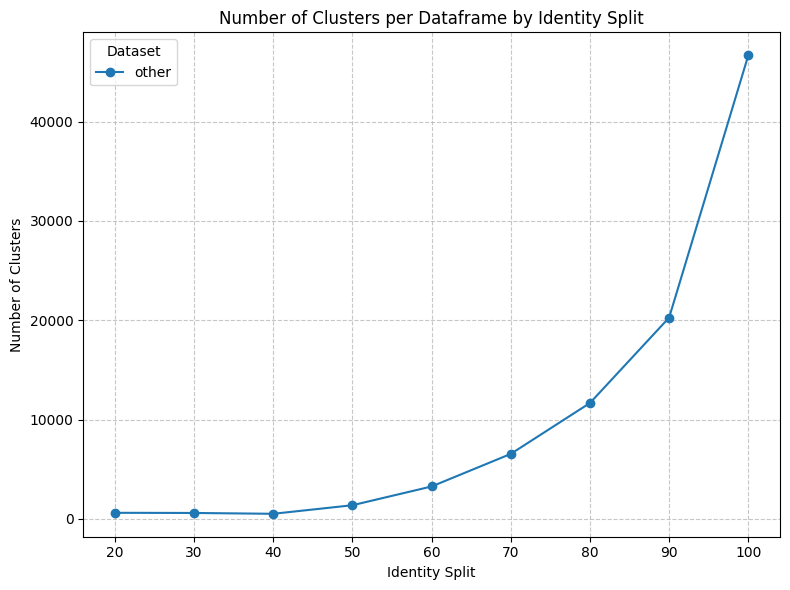

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def count_clusters(df_list, label):
    """Count clusters per dataframe at one similarity level."""
    counts = []
    for df in df_list:
        # Defensive checks
        required = {"source_file", "clstr_rep"}
        missing = required - set(df.columns)
        if missing:
            print(f"Warning: skipping df at similarity {label}; missing columns: {missing}")
            continue

        # Dataset type from 'source_file'
        src = str(df["source_file"].iloc[0]).lower()
        if "train" in src:
            dtype = "train"
        elif "test" in src:
            dtype = "test"
        elif "val" in src or "valid" in src:
            dtype = "val"
        else:
            dtype = "other"

        # Representatives indicate clusters
        try:
            n_clusters = (df["clstr_rep"] == 1).sum()
        except Exception as e:
            print(f"Warning: could not count clusters for {src} at {label}%: {e}")
            continue

        counts.append({
            "similarity": int(label),
            "num_clusters": int(n_clusters),
            "dataset": dtype,
            "source_file": df["source_file"].iloc[0],
        })
    return pd.DataFrame(counts)

# ---- Build summary across all similarity levels (now includes 20, 30, 100) ----
groups = [
    ("20",  dataframes_20),
    ("30",  dataframes_30),
    ("40",  dataframes_40),
    ("50",  dataframes_50),
    ("60",  dataframes_60),
    ("70",  dataframes_70),
    ("80",  dataframes_80),
    ("90",  dataframes_90),
    ("100", dataframes_100),
]

frames = []
for label, dfs in groups:
    if dfs:  # skip empty lists
        frames.append(count_clusters(dfs, label))

summary = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=["similarity","num_clusters","dataset","source_file"])

# ---- Plot: mean clusters per similarity for each dataset type ----
if summary.empty:
    print("No data to plot (summary is empty).")
else:
    # ensure proper sorting by numeric similarity
    summary["similarity"] = summary["similarity"].astype(int)
    summary = summary.sort_values("similarity")

    plt.figure(figsize=(8, 6))
    for dtype, subset in summary.groupby("dataset"):
        means = subset.groupby("similarity", as_index=False)["num_clusters"].mean()
        plt.plot(means["similarity"], means["num_clusters"], marker="o", label=dtype)

    plt.title("Number of Clusters per Dataframe by Identity Split")
    plt.xlabel("Identity Split")
    plt.ylabel("Number of Clusters")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()


In [ ]:
#pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


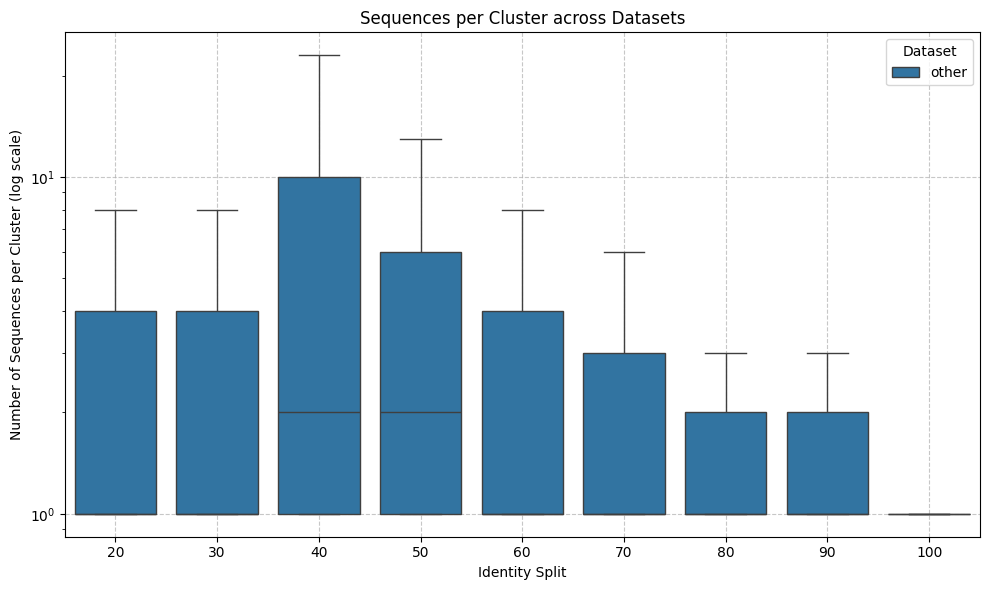

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def cluster_sizes(df_list, label):
    """Return per-cluster sizes for one similarity level."""
    out = []
    for df in df_list:
        # Defensive columns check
        required = {"source_file", "clstr"}
        missing = required - set(df.columns)
        if missing:
            print(f"Warning: skipping a df at {label}% (missing {missing})")
            continue

        src = str(df["source_file"].iloc[0]).lower()
        if "train" in src:
            dtype = "train"
        elif "test" in src:
            dtype = "test"
        elif "val" in src or "valid" in src:
            dtype = "val"
        else:
            dtype = "other"

        sizes = df.groupby("clstr").size().reset_index(name="seqs_per_cluster")
        sizes["similarity"] = int(label)
        sizes["dataset"] = dtype
        out.append(sizes)

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(
        columns=["clstr", "seqs_per_cluster", "similarity", "dataset"]
    )

# ---- Collect across all similarity levels (now includes 20, 30, 100) ----
groups = [
    ("20",  dataframes_20),
    ("30",  dataframes_30),
    ("40",  dataframes_40),
    ("50",  dataframes_50),
    ("60",  dataframes_60),
    ("70",  dataframes_70),
    ("80",  dataframes_80),
    ("90",  dataframes_90),
    ("100", dataframes_100),
]

parts = [cluster_sizes(dfs, lbl) for lbl, dfs in groups if dfs]
sizes_summary = (pd.concat(parts, ignore_index=True)
                 if parts
                 else pd.DataFrame(columns=["clstr","seqs_per_cluster","similarity","dataset"]))

# ---- Plot distributions ----
if sizes_summary.empty:
    print("No data to plot (sizes_summary is empty).")
else:
    # nice ordering on x-axis
    order = [20, 30, 40, 50, 60, 70, 80, 90, 100]
    sizes_summary["similarity"] = sizes_summary["similarity"].astype(int)
    sizes_summary = sizes_summary[sizes_summary["similarity"].isin(order)]
    sizes_summary = sizes_summary.sort_values("similarity")

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=sizes_summary,
        x="similarity", y="seqs_per_cluster",
        hue="dataset", showfliers=False
    )
    plt.yscale("log")
    plt.title("Sequences per Cluster across Datasets")
    plt.xlabel("Identity Split")
    plt.ylabel("Number of Sequences per Cluster (log scale)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()


In [8]:
#pip install scikit-learn

In [13]:
import pandas as pd
import numpy as np

def split_df_by_cluster(df, train_frac=0.6, val_frac=0.2, seed=42, clstr_col="clstr"):
    """
    Split a single dataframe into train/val/test by CLUSTER.
    A given cluster (clstr_col) will appear in exactly one split.

    Handles small numbers of clusters:
      - 1 cluster: all -> train
      - 2 clusters: train/test, val empty
      - >=3 clusters: train/val/test by requested fractions (rounded)
    """
    if clstr_col not in df.columns:
        raise ValueError(f"Required column '{clstr_col}' not found.")

    # Normalize cluster labels and drop NaNs
    d = df.copy()
    d = d[~d[clstr_col].isna()].copy()
    d[clstr_col] = d[clstr_col].astype(str)

    clusters = np.array(sorted(d[clstr_col].unique()))
    n = len(clusters)

    # Edge cases
    if n == 0:
        # Empty input
        return d.iloc[0:0].copy(), d.iloc[0:0].copy(), d.iloc[0:0].copy()
    if n == 1:
        tr = d[d[clstr_col] == clusters[0]].copy()
        return tr, d.iloc[0:0].copy(), d.iloc[0:0].copy()
    if n == 2:
        rng = np.random.RandomState(seed)
        rng.shuffle(clusters)
        tr = d[d[clstr_col] == clusters[0]].copy()
        te = d[d[clstr_col] == clusters[1]].copy()
        return tr, d.iloc[0:0].copy(), te

    # General case (>=3 clusters)
    rng = np.random.RandomState(seed)
    rng.shuffle(clusters)

    # Compute counts ensuring at least 1 cluster in train and test
    n_train = max(1, int(round(train_frac * n)))
    n_val   = int(round(val_frac * n))
    n_train = min(n_train, n-2)  # leave room for val & test
    remaining = n - n_train
    n_val = min(n_val, remaining-1)  # leave >=1 for test
    n_test = n - n_train - n_val
    if n_test < 1:
        # steal from val if needed
        n_val = max(0, n_val - (1 - n_test))
        n_test = 1

    train_clusters = set(clusters[:n_train])
    val_clusters   = set(clusters[n_train:n_train+n_val])
    test_clusters  = set(clusters[n_train+n_val:])

    train = d[d[clstr_col].isin(train_clusters)].copy()
    val   = d[d[clstr_col].isin(val_clusters)].copy()
    test  = d[d[clstr_col].isin(test_clusters)].copy()

    # Sanity check: no cluster overlap
    assert train[clstr_col].isna().sum() == 0
    assert val[clstr_col].isna().sum() == 0
    assert test[clstr_col].isna().sum() == 0
    assert train[clstr_col].is_unique or True  # rows can repeat; clusters must not cross splits
    assert len(set(train[clstr_col]).intersection(val[clstr_col])) == 0
    assert len(set(train[clstr_col]).intersection(test[clstr_col])) == 0
    assert len(set(val[clstr_col]).intersection(test[clstr_col])) == 0

    return train, val, test


def split_dataframes(dfs, train_frac=0.6, val_frac=0.2, seed=42, clstr_col="clstr"):
    """Apply split_df_by_cluster to a list of dataframes."""
    train_dfs, val_dfs, test_dfs = [], [], []
    for df in dfs:
        tr, va, te = split_df_by_cluster(df, train_frac, val_frac, seed, clstr_col)
        train_dfs.append(tr)
        val_dfs.append(va)
        test_dfs.append(te)
    return train_dfs, val_dfs, test_dfs


# ---- Run for all similarity groups (20, 30, 40, 50, 60, 70, 80, 90, 100) ----
train_20,  val_20,  test_20  = split_dataframes(dataframes_20)
train_30,  val_30,  test_30  = split_dataframes(dataframes_30)
train_40,  val_40,  test_40  = split_dataframes(dataframes_40)
train_50,  val_50,  test_50  = split_dataframes(dataframes_50)
train_60,  val_60,  test_60  = split_dataframes(dataframes_60)
train_70,  val_70,  test_70  = split_dataframes(dataframes_70)
train_80,  val_80,  test_80  = split_dataframes(dataframes_80)
train_90,  val_90,  test_90  = split_dataframes(dataframes_90)
train_100, val_100, test_100 = split_dataframes(dataframes_100)

# Example quick peek (40%)
if train_40:
    print("Train 40% head:")
    print(train_40[0].head())
if val_40:
    print("Val 40% head:")
    print(val_40[0].head())
if test_40:
    print("Test 40% head:")
    print(test_40[0].head())


Train 40% head:
               id clstr  clstr_size  length  clstr_rep clstr_iden clstr_cov  \
0     34506.g3059    16       10293    1102          1        100      100%   
1  WP_084267161.1    91        7179     666          1        100      100%   
3      A0A0K3W7L9    75        4930     728          1        100      100%   
5      A0A034TX30   279        3677     342          1        100      100%   
8  mgg:MPLG2_0372   147        2556     585          1        100      100%   

  source_file  similarity  
0   asssulred          40  
1   asssulred          40  
3   asssulred          40  
5   asssulred          40  
8   asssulred          40  
Val 40% head:
                     id clstr  clstr_size  length  clstr_rep clstr_iden  \
4            A0A1N5KMF7    25        3830    1045          1        100   
7   bpm:BURPS1710b_2649   103        2609     639          1        100   
17       WP_121392310.1   170        1355     557          1        100   
18       WP_095208034.1   2

In [14]:
# Helper to safely concat (avoids errors if list is empty)
def safe_concat(dfs):
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


combined_train_20 = safe_concat(train_20)
combined_val_20   = safe_concat(val_20)
combined_test_20  = safe_concat(test_20)

# ---- 30% ----
combined_train_30 = safe_concat(train_30)
combined_val_30   = safe_concat(val_30)
combined_test_30  = safe_concat(test_30)

# ---- 40% ----
combined_train_40 = safe_concat(train_40)
combined_val_40   = safe_concat(val_40)
combined_test_40  = safe_concat(test_40)

# ---- 50% ----
combined_train_50 = safe_concat(train_50)
combined_val_50   = safe_concat(val_50)
combined_test_50  = safe_concat(test_50)

# ---- 60% ----
combined_train_60 = safe_concat(train_60)
combined_val_60   = safe_concat(val_60)
combined_test_60  = safe_concat(test_60)

# ---- 70% ----
combined_train_70 = safe_concat(train_70)
combined_val_70   = safe_concat(val_70)
combined_test_70  = safe_concat(test_70)

# ---- 80% ----
combined_train_80 = safe_concat(train_80)
combined_val_80   = safe_concat(val_80)
combined_test_80  = safe_concat(test_80)

# ---- 90% ----
combined_train_90 = safe_concat(train_90)
combined_val_90   = safe_concat(val_90)
combined_test_90  = safe_concat(test_90)

# ---- 100% ----
combined_train_100 = safe_concat(train_100)
combined_val_100   = safe_concat(val_100)
combined_test_100  = safe_concat(test_100)

# Example check
print("Combined training dataframe with 40% similarity:")
print(combined_train_40.head())


Combined training dataframe with 40% similarity:
               id clstr  clstr_size  length  clstr_rep clstr_iden clstr_cov  \
0     34506.g3059    16       10293    1102          1        100      100%   
1  WP_084267161.1    91        7179     666          1        100      100%   
2      A0A0K3W7L9    75        4930     728          1        100      100%   
3      A0A034TX30   279        3677     342          1        100      100%   
4  mgg:MPLG2_0372   147        2556     585          1        100      100%   

  source_file  similarity  
0   asssulred          40  
1   asssulred          40  
2   asssulred          40  
3   asssulred          40  
4   asssulred          40  


In [16]:
import os

# Directory to save the CSV files
output_dir = "../../splitting_output"  # change if desired
os.makedirs(output_dir, exist_ok=True)

def write_dataframes_to_csv(train, val, test, similarity):
    """Write split dataframes to CSV; warns if any are empty/missing."""
    if train is None or val is None or test is None:
        print(f"[WARN] Missing split(s) for {similarity}%. Skipping.")
        return
    if getattr(train, "empty", True) and getattr(val, "empty", True) and getattr(test, "empty", True):
        print(f"[WARN] All splits empty for {similarity}%. Skipping.")
        return

    train.to_csv(os.path.join(output_dir, f"train_{similarity}.csv"), index=False)
    val.to_csv(os.path.join(output_dir, f"val_{similarity}.csv"), index=False)
    test.to_csv(os.path.join(output_dir, f"test_{similarity}.csv"), index=False)
    print(f"[OK] Wrote train/val/test for {similarity}%")

# Levels to export (now includes 20, 30, 100)
levels = ["20","30","40","50","60","70","80","90","100"]

for lvl in levels:
    train_df = globals().get(f"combined_train_{lvl}")
    val_df   = globals().get(f"combined_val_{lvl}")
    test_df  = globals().get(f"combined_test_{lvl}")
    write_dataframes_to_csv(train_df, val_df, test_df, lvl)

print("All requested files have been written (where available).")


[OK] Wrote train/val/test for 20%
[OK] Wrote train/val/test for 30%
[OK] Wrote train/val/test for 40%
[OK] Wrote train/val/test for 50%
[OK] Wrote train/val/test for 60%
[OK] Wrote train/val/test for 70%
[OK] Wrote train/val/test for 80%
[OK] Wrote train/val/test for 90%
[OK] Wrote train/val/test for 100%
All requested files have been written (where available).


In [17]:
!pwd

/Users/wynne/Dropbox/BioGeoFormer/BGF_clustering/cycle_division_split/cycle_splits_cdhit


In [18]:
import pandas as pd
import os

os.chdir('../../')

# Directory containing combined100 file
output_dir = "../BioGeoFormer_db"

# Read the combined100 file (ensure 'id' is string)
combined_100_df = pd.read_csv(os.path.join(output_dir, "BioGeoFormer_db.csv"))
if "id" not in combined_100_df.columns:
    raise KeyError("'id' column not found in BioGeoFormer_db.csv")
combined_100_df["id"] = combined_100_df["id"].astype(str)

def merge_with_combined_100(train, val, test, combined_100_df, how="inner"):
    """Merge split dfs with combined_100_df on 'id'. Casts id to string to avoid dtype issues."""
    for name, df in [("train", train), ("val", val), ("test", test)]:
        if "id" not in df.columns:
            raise KeyError(f"'id' column missing in {name} dataframe.")
    train = train.copy(); val = val.copy(); test = test.copy()
    train["id"] = train["id"].astype(str)
    val["id"]   = val["id"].astype(str)
    test["id"]  = test["id"].astype(str)

    merged_train = pd.merge(train, combined_100_df, on="id", how=how, suffixes=("", "_meta"))
    merged_val   = pd.merge(val,   combined_100_df, on="id", how=how, suffixes=("", "_meta"))
    merged_test  = pd.merge(test,  combined_100_df, on="id", how=how, suffixes=("", "_meta"))
    return merged_train, merged_val, merged_test

# Which similarity levels to process (now includes 20, 30, 100)
levels = ["20","30","40","50","60","70","80","90","100"]

# Perform merges and create variables like merged_train_40, merged_val_40, merged_test_40
for lvl in levels:
    train_df = globals().get(f"combined_train_{lvl}")
    val_df   = globals().get(f"combined_val_{lvl}")
    test_df  = globals().get(f"combined_test_{lvl}")

    if train_df is None or val_df is None or test_df is None:
        print(f"[WARN] Missing combined splits for {lvl}%. Skipping.")
        continue

    mtrain, mval, mtest = merge_with_combined_100(train_df, val_df, test_df, combined_100_df, how="inner")
    globals()[f"merged_train_{lvl}"] = mtrain
    globals()[f"merged_val_{lvl}"]   = mval
    globals()[f"merged_test_{lvl}"]  = mtest
    print(f"[OK] Merged splits for {lvl}% (rows: train={len(mtrain)}, val={len(mval)}, test={len(mtest)})")


[OK] Merged splits for 20% (rows: train=663559, val=228375, test=269963)
[OK] Merged splits for 30% (rows: train=667383, val=228378, test=270028)
[OK] Merged splits for 40% (rows: train=842513, val=226213, test=334162)
[OK] Merged splits for 50% (rows: train=882630, val=242222, test=290087)
[OK] Merged splits for 60% (rows: train=900706, val=276332, test=264429)
[OK] Merged splits for 70% (rows: train=854577, val=324301, test=303612)
[OK] Merged splits for 80% (rows: train=931025, val=300165, test=307698)
[OK] Merged splits for 90% (rows: train=966591, val=327634, test=331026)
[OK] Merged splits for 100% (rows: train=975188, val=325063, test=324999)


In [19]:
# QA/QC for duplicate IDs (Python 3.8/3.9 compatible)

import os
import pandas as pd
from itertools import combinations
from typing import Optional, Dict

# ----------------------
# Config
# ----------------------
LEVELS = ["20","30","40","50","60","70","80","90","100"]
SPLITS = ["train","val","test"]
DF_PREFIX = "merged"      # or "combined" (expects variables like combined_train_40, etc.)
ID_COL = "id"
SAVE_DIR = None           # e.g., "/path/to/qaqc_reports"; use None to skip saving
MAX_SHOW = 20             # how many example IDs to print per issue

if SAVE_DIR:
    os.makedirs(SAVE_DIR, exist_ok=True)

# ----------------------
# Helpers
# ----------------------
def get_df(name: str) -> Optional[pd.DataFrame]:
    """Fetch a dataframe by variable name from globals, ensure ID_COL present, cast id to str."""
    df = globals().get(name)
    if df is None:
        print("[WARN] Missing dataframe: {}".format(name))
        return None
    if ID_COL not in df.columns:
        print("[WARN] {} missing '{}' column; skipping.".format(name, ID_COL))
        return None
    df = df.copy()
    df[ID_COL] = df[ID_COL].astype(str)
    return df

def write_csv(df: pd.DataFrame, fname: str) -> None:
    if SAVE_DIR and df is not None and not df.empty:
        path = os.path.join(SAVE_DIR, fname)
        df.to_csv(path, index=False)
        print("[OK] wrote {} ({} rows)".format(fname, len(df)))

# ----------------------
# 1) Within-DF duplicate checks
# ----------------------
def check_within_duplicates() -> pd.DataFrame:
    rows = []
    for lvl in LEVELS:
        for sp in SPLITS:
            name = "{}_{}_{}".format(DF_PREFIX, sp, lvl)
            df = get_df(name)
            if df is None:
                continue

            dup_mask = df[ID_COL].duplicated(keep=False)
            n_dup_rows = int(dup_mask.sum())
            rows.append({
                "dataframe": name,
                "rows": int(len(df)),
                "duplicate_id_rows": n_dup_rows,
                "unique_ids": int(df[ID_COL].nunique()),
                "has_duplicates": bool(n_dup_rows > 0)
            })

            if n_dup_rows > 0:
                ex = df.loc[dup_mask, ID_COL].value_counts().head(MAX_SHOW)
                print("\n[WITHIN] {}: {} duplicate rows for IDs (showing up to {}):"
                      .format(name, n_dup_rows, MAX_SHOW))
                print(ex.to_string())
                write_csv(df.loc[dup_mask, [ID_COL]], "within_dups_{}.csv".format(name))

    if rows:
        summary = pd.DataFrame(rows)
        summary = summary.sort_values(["has_duplicates","duplicate_id_rows"], ascending=False)
        write_csv(summary, "summary_within_duplicates.csv")
        return summary
    return pd.DataFrame(columns=["dataframe","rows","duplicate_id_rows","unique_ids","has_duplicates"])

# ----------------------
# 2) Leakage between splits at each level (train/val/test)
# ----------------------
def check_between_splits() -> pd.DataFrame:
    all_rows = []
    for lvl in LEVELS:
        # Collect ID sets for this level only
        id_sets = {}
        for sp in SPLITS:
            name = "{}_{}_{}".format(DF_PREFIX, sp, lvl)
            df = get_df(name)
            if df is not None and not df.empty:
                id_sets[sp] = set(df[ID_COL])
            else:
                id_sets[sp] = set()

        # Pairwise overlaps within this level
        for a, b in combinations(SPLITS, 2):
            overlap = id_sets[a].intersection(id_sets[b])
            n = len(overlap)
            all_rows.append({"level": lvl, "pair": "{}-{}".format(a, b), "overlap_ids": int(n)})
            if n > 0:
                print("\n[LEAKAGE] Level {}: {}∩{} = {} IDs (showing up to {}):"
                      .format(lvl, a, b, n, MAX_SHOW))
                print(pd.Series(list(overlap)[:MAX_SHOW]).to_string(index=False))
                write_csv(pd.DataFrame({ID_COL: sorted(overlap)}),
                          "leakage_{}_{}_{}.csv".format(lvl, a, b))

    if all_rows:
        summary = pd.DataFrame(all_rows)
        summary = (summary
                   .pivot(index="level", columns="pair", values="overlap_ids")
                   .fillna(0).astype(int))
        write_csv(summary.reset_index(), "summary_between_split_leakage.csv")
        return summary
    return pd.DataFrame()

# ----------------------
# Run checks
# ----------------------
if __name__ == "__main__":
    print("\n=== QA/QC: Within-DF duplicates ===")
    within_summary = check_within_duplicates()

    print("\n=== QA/QC: Leakage between train/val/test within each similarity level ===")
    between_summary = check_between_splits()

    print("\nDone QA/QC. (Cross-level overlaps were intentionally NOT checked.)")



=== QA/QC: Within-DF duplicates ===

[WITHIN] merged_train_20: 16 duplicate rows for IDs (showing up to 20):
id
1236976.JCM16418_11    3
876044.IMCC3088_126    3
elq:Ga0102493_11130    2
elq:Ga0102493_11131    2
1423806.JCM15457_30    2
1423806.JCM15457_39    2
754436.JCM19237_476    2

[WITHIN] merged_val_20: 4 duplicate rows for IDs (showing up to 20):
id
1423806.JCM15457_37    2
1294265.JCM21738_23    2

[WITHIN] merged_test_20: 2 duplicate rows for IDs (showing up to 20):
id
869213.JCM21142_414    2

[WITHIN] merged_train_30: 16 duplicate rows for IDs (showing up to 20):
id
1236976.JCM16418_11    3
876044.IMCC3088_126    3
elq:Ga0102493_11130    2
elq:Ga0102493_11131    2
1423806.JCM15457_30    2
1423806.JCM15457_39    2
754436.JCM19237_476    2

[WITHIN] merged_val_30: 4 duplicate rows for IDs (showing up to 20):
id
1423806.JCM15457_37    2
1294265.JCM21738_23    2

[WITHIN] merged_test_30: 2 duplicate rows for IDs (showing up to 20):
id
869213.JCM21142_414    2

[WITHIN] merged_

In [20]:
import pandas as pd

LEVELS = ["20","30","40","50","60","70","80","90","100"]

for lvl in LEVELS:
    t = globals().get(f"merged_train_{lvl}")
    v = globals().get(f"merged_val_{lvl}")
    s = globals().get(f"merged_test_{lvl}")

    if t is None or v is None or s is None:
        continue

    # 1. Deduplicate within each split
    t = t.drop_duplicates(subset="id", keep="first")
    v = v.drop_duplicates(subset="id", keep="first")
    s = s.drop_duplicates(subset="id", keep="first")

    # 2. Identify ids present in more than one split
    all_ids = pd.concat([t[["id"]], v[["id"]], s[["id"]]])
    dup_ids = all_ids["id"][all_ids["id"].duplicated()].unique()

    # 3. Remove those ids from *all* splits
    if len(dup_ids) > 0:
        print(f"[CLEAN] Level {lvl}: removing {len(dup_ids)} leaked ids across splits")
        t = t[~t["id"].isin(dup_ids)]
        v = v[~v["id"].isin(dup_ids)]
        s = s[~s["id"].isin(dup_ids)]

    # Save cleaned splits back to globals with new names
    globals()[f"final_train_{lvl}"] = t.reset_index(drop=True)
    globals()[f"final_val_{lvl}"]   = v.reset_index(drop=True)
    globals()[f"final_test_{lvl}"]  = s.reset_index(drop=True)

print("✅ Done. Each split now has unique IDs, and no leakage across train/val/test.")


[CLEAN] Level 20: removing 13 leaked ids across splits
[CLEAN] Level 30: removing 13 leaked ids across splits
[CLEAN] Level 40: removing 15 leaked ids across splits
[CLEAN] Level 50: removing 16 leaked ids across splits
[CLEAN] Level 60: removing 21 leaked ids across splits
[CLEAN] Level 70: removing 16 leaked ids across splits
[CLEAN] Level 80: removing 19 leaked ids across splits
[CLEAN] Level 90: removing 18 leaked ids across splits
[CLEAN] Level 100: removing 14 leaked ids across splits
✅ Done. Each split now has unique IDs, and no leakage across train/val/test.


In [21]:
import pandas as pd

LEVELS = ["20","30","40","50","60","70","80","90","100"]

for lvl in LEVELS:
    t = globals().get(f"final_train_{lvl}")
    v = globals().get(f"final_val_{lvl}")
    s = globals().get(f"final_test_{lvl}")

    if t is None or v is None or s is None:
        continue

    print(f"\n=== QA/QC for Level {lvl}% ===")

    # --- Within-split duplicate check ---
    for name, df in [("train", t), ("val", v), ("test", s)]:
        dup_ids = df["id"][df["id"].duplicated()].unique()
        if len(dup_ids) > 0:
            print(f"[WITHIN] {name}: {len(dup_ids)} duplicate ids (showing up to 10): {dup_ids[:10]}")
        else:
            print(f"[WITHIN] {name}: no duplicate ids ✅")

    # --- Cross-split leakage check ---
    ids_train, ids_val, ids_test = set(t["id"]), set(v["id"]), set(s["id"])
    ov_tv = ids_train & ids_val
    ov_tt = ids_train & ids_test
    ov_vt = ids_val & ids_test
    total_leaks = len(ov_tv | ov_tt | ov_vt)

    if total_leaks > 0:
        print(f"[LEAKAGE] {total_leaks} ids overlap across splits at level {lvl}")
        if ov_tv: print(f"   train∩val = {len(ov_tv)} (e.g. {list(ov_tv)[:5]})")
        if ov_tt: print(f"   train∩test = {len(ov_tt)} (e.g. {list(ov_tt)[:5]})")
        if ov_vt: print(f"   val∩test = {len(ov_vt)} (e.g. {list(ov_vt)[:5]})")
    else:
        print(f"[LEAKAGE] no cross-split overlaps ✅")



=== QA/QC for Level 20% ===
[WITHIN] train: no duplicate ids ✅
[WITHIN] val: no duplicate ids ✅
[WITHIN] test: no duplicate ids ✅
[LEAKAGE] no cross-split overlaps ✅

=== QA/QC for Level 30% ===
[WITHIN] train: no duplicate ids ✅
[WITHIN] val: no duplicate ids ✅
[WITHIN] test: no duplicate ids ✅
[LEAKAGE] no cross-split overlaps ✅

=== QA/QC for Level 40% ===
[WITHIN] train: no duplicate ids ✅
[WITHIN] val: no duplicate ids ✅
[WITHIN] test: no duplicate ids ✅
[LEAKAGE] no cross-split overlaps ✅

=== QA/QC for Level 50% ===
[WITHIN] train: no duplicate ids ✅
[WITHIN] val: no duplicate ids ✅
[WITHIN] test: no duplicate ids ✅
[LEAKAGE] no cross-split overlaps ✅

=== QA/QC for Level 60% ===
[WITHIN] train: no duplicate ids ✅
[WITHIN] val: no duplicate ids ✅
[WITHIN] test: no duplicate ids ✅
[LEAKAGE] no cross-split overlaps ✅

=== QA/QC for Level 70% ===
[WITHIN] train: no duplicate ids ✅
[WITHIN] val: no duplicate ids ✅
[WITHIN] test: no duplicate ids ✅
[LEAKAGE] no cross-split overlaps 

In [22]:
!pwd

/Users/wynne/Dropbox/BioGeoFormer/BGF_clustering


In [23]:
import os

# Directory where you want the CSVs
save_dir = "./cleaned_unselected"
os.makedirs(save_dir, exist_ok=True)

# Function to write the final cleaned dataframes
def write_final_dataframes_to_csv(train, val, test, similarity):
    train.to_csv(os.path.join(save_dir, f'final_train_{similarity}.csv'), index=False)
    val.to_csv(os.path.join(save_dir, f'final_val_{similarity}.csv'), index=False)
    test.to_csv(os.path.join(save_dir, f'final_test_{similarity}.csv'), index=False)

# Loop through all similarity levels
for lvl in ["20","30","40","50","60","70","80","90","100"]:
    t = globals().get(f"final_train_{lvl}")
    v = globals().get(f"final_val_{lvl}")
    s = globals().get(f"final_test_{lvl}")

    if t is None or v is None or s is None:
        continue

    write_final_dataframes_to_csv(t, v, s, lvl)

print("✅ All cleaned (final) files have been written to CSV.")


✅ All cleaned (final) files have been written to CSV.


In [24]:
print(final_train_40.columns)

Index(['id', 'clstr', 'clstr_size', 'length', 'clstr_rep', 'clstr_iden',
       'clstr_cov', 'source_file', 'similarity', 'gene', 'cycle', 'sequence'],
      dtype='object')


In [25]:
import os

# Directory for the selected-column outputs
selected_dir = "./train_test_val_final"
os.makedirs(selected_dir, exist_ok=True)

# Columns to select
columns_to_select = ['id', 'gene', 'cycle', 'sequence']

# Function to select specific columns if they exist
def select_columns(df, columns):
    available_columns = [col for col in columns if col in df.columns]
    return df[available_columns]

# Function to write selected columns to CSV
def write_selected_dataframes_to_csv(train, val, test, similarity):
    train.to_csv(os.path.join(selected_dir, f'final_selected_train_{similarity}.csv'), index=False)
    val.to_csv(os.path.join(selected_dir, f'final_selected_val_{similarity}.csv'), index=False)
    test.to_csv(os.path.join(selected_dir, f'final_selected_test_{similarity}.csv'), index=False)

# Loop over all similarity levels
for lvl in ["20","30","40","50","60","70","80","90","100"]:
    t = globals().get(f"final_train_{lvl}")
    v = globals().get(f"final_val_{lvl}")
    s = globals().get(f"final_test_{lvl}")

    if t is None or v is None or s is None:
        continue

    selected_t = select_columns(t, columns_to_select)
    selected_v = select_columns(v, columns_to_select)
    selected_s = select_columns(s, columns_to_select)

    write_selected_dataframes_to_csv(selected_t, selected_v, selected_s, lvl)

print("✅ All final selected-column files have been written to CSV.")


✅ All final selected-column files have been written to CSV.
